In [1]:
import torch
import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns

from hydra import initialize, compose
from hydra.utils import instantiate

from pathlib import Path

from bliss.surveys.dc2 import DC2DataModule
from bliss.catalog import TileCatalog
from bliss.encoder.encoder import Encoder

from pytorch_lightning.utilities import move_data_to_device

from case_studies.dc2_cataloging.utils.bootstrap_tile_cat import bootstrap_tile_cat
from case_studies.dc2_cataloging.utils.notebook_variables import NoteBookVariables
from case_studies.dc2_cataloging.utils.safe_metric_collection import SafeMetricCollection as MetricCollection
from case_studies.dc2_cataloging.utils.metrics import EllipticityMSE

output_dir = Path("./ellipticity_bootstrap_output/")
output_dir.mkdir(parents=True, exist_ok=True)

# change this model path according to your training setting
model_path = "../../../bliss_output/DC2_cataloging_exp_07/exp_07-22-1/checkpoints/best_encoder.ckpt"
lsst_root_dir = "/data/scratch/dc2_nfs/"

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [2]:
with initialize(config_path=".", version_base=None):
    notebook_cfg = compose("notebook_config")

In [3]:
tile_slen = notebook_cfg.surveys.dc2.tile_slen
max_sources_per_tile = notebook_cfg.surveys.dc2.max_sources_per_tile
r_band_min_flux = notebook_cfg.encoder.min_flux_for_metrics

dc2: DC2DataModule = instantiate(notebook_cfg.surveys.dc2)
dc2.setup(stage="validate")
dc2_val_dataloader = dc2.val_dataloader()

bliss_encoder: Encoder = instantiate(notebook_cfg.encoder).to(device=device)
pretrained_weights = torch.load(model_path, map_location=device)["state_dict"]
bliss_encoder.load_state_dict(pretrained_weights)
bliss_encoder = bliss_encoder.eval()

In [4]:
def move_tile_cat_to_device(ori_tile_cat: TileCatalog, device):
    tile_dict = move_data_to_device(ori_tile_cat.data, device=device)
    return TileCatalog(ori_tile_cat.tile_slen, tile_dict)

In [5]:
bliss_tile_cat_list = []
target_tile_cat_list = []
for batch in tqdm.tqdm(dc2_val_dataloader):
    batch_on_device = move_data_to_device(batch, device=device)
    target_tile_cat = TileCatalog(tile_slen, batch["tile_catalog"])
    target_tile_cat = target_tile_cat.filter_by_flux(
            min_flux=r_band_min_flux,
            band=2,  # default is r band
        )
    with torch.no_grad():
        bliss_tile_cat = bliss_encoder.sample(batch_on_device, use_mode=True)
        bliss_tile_cat = bliss_tile_cat.filter_by_flux(
            min_flux=r_band_min_flux,
            band=2,
        )
    target_tile_cat_list.append(move_tile_cat_to_device(target_tile_cat, device="cpu"))
    bliss_tile_cat_list.append(move_tile_cat_to_device(bliss_tile_cat, device="cpu"))

100%|██████████| 391/391 [01:50<00:00,  3.53it/s]


In [6]:
# bootstrap
matcher = instantiate(notebook_cfg.encoder.matcher)
mag_bin_cutoffs = [23.9, 24.1, 24.5, 24.9, 25.6]
blendedness_cutoffs = [0.001, 0.02, 0.1, 0.2, 0.6]
bliss_metrics = MetricCollection({
    "ellipticity_mse_mag": EllipticityMSE(bin_cutoffs=mag_bin_cutoffs, bin_type="Mag"),
    "ellipticity_mse_blendedness": EllipticityMSE(bin_cutoffs=blendedness_cutoffs, bin_type="Blendedness"),
})
bliss_mag_results = {}
bliss_blendedness_results = {}

epochs_num = 10
for epoch in range(epochs_num):
    print(f"Epoch: {epoch}")
    seed = random.randint(1e4, 1e5 - 1)
    for bliss_tile_cat, target_tile_cat in tqdm.tqdm(zip(bliss_tile_cat_list, 
                                                         target_tile_cat_list)):
        bliss_full_cat = bootstrap_tile_cat(bliss_tile_cat, seed=seed).to_full_catalog()
        target_full_cat = bootstrap_tile_cat(target_tile_cat, seed=seed).to_full_catalog()

        bliss_matching = matcher.match_catalogs(target_full_cat, bliss_full_cat)
        bliss_metrics.update(target_full_cat, bliss_full_cat, bliss_matching)

    mag_results = bliss_metrics["ellipticity_mse_mag"].get_results_on_per_bin()
    for k_state, v_state in mag_results.items():
        if k_state not in bliss_mag_results:
            bliss_mag_results[k_state] = []
        bliss_mag_results[k_state].append(v_state)

    blendedness_results = bliss_metrics["ellipticity_mse_blendedness"].get_results_on_per_bin()
    for k_state, v_state in blendedness_results.items():
        if k_state not in bliss_blendedness_results:
            bliss_blendedness_results[k_state] = []
        bliss_blendedness_results[k_state].append(v_state)

    bliss_metrics.reset()

bliss_mag_results = {k: torch.stack(v) for k, v in bliss_mag_results.items()}
bliss_blendedness_results = {k: torch.stack(v) for k, v in bliss_blendedness_results.items()}

Epoch: 0


391it [02:07,  3.06it/s]


Epoch: 1


391it [02:01,  3.23it/s]


Epoch: 2


391it [02:03,  3.17it/s]


Epoch: 3


391it [01:52,  3.47it/s]


Epoch: 4


391it [01:56,  3.36it/s]


Epoch: 5


391it [01:54,  3.40it/s]


Epoch: 6


391it [01:59,  3.28it/s]


Epoch: 7


391it [01:47,  3.64it/s]


Epoch: 8


391it [01:55,  3.38it/s]


Epoch: 9


391it [01:50,  3.54it/s]


In [22]:
def plot_with_error_bar(g1_mag_matrix, g1_blendedness_matrix, 
                        g2_mag_matrix, g2_blendedness_matrix,
                        mag_bin_cutoffs, blendedness_bin_cutoffs):
    mag_xlabels = (
        ["< " + str(mag_bin_cutoffs[0])]
        + [f"[{mag_bin_cutoffs[i]}, {mag_bin_cutoffs[i + 1]}]" for i in range(len(mag_bin_cutoffs) - 1)]
        + ["> " + str(mag_bin_cutoffs[-1])]
    )
    mag_x = list(range(len(mag_xlabels)))

    blendedness_xlabels = (
        ["< " + str(blendedness_bin_cutoffs[0])]
        + [f"[{blendedness_bin_cutoffs[i]}, {blendedness_bin_cutoffs[i + 1]}]" for i in range(len(blendedness_bin_cutoffs) - 1)]
        + ["> " + str(blendedness_bin_cutoffs[-1])]
    )
    blendedness_x = list(range(len(blendedness_xlabels)))

    sns.set_theme(style="whitegrid")
    color_list = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    
    fig, axes = plt.subplots(2, 2, sharey="row", sharex="col", figsize=NoteBookVariables.figsize)
    
    # g1
    axes[0, 0].plot(mag_x, 
                    g1_mag_matrix[1, :],
                    "-o",
                    color=color_list[0],
                    label="BLISS")
    axes[0, 0].fill_between(mag_x,
                            g1_mag_matrix[0, :],
                            g1_mag_matrix[2, :],
                            color=color_list[0],
                            alpha=0.5)
    axes[0, 0].set_ylabel(r"MSE of $g_1$", fontsize=NoteBookVariables.font_size)
    axes[0, 0].tick_params(labelsize=NoteBookVariables.font_size)
    axes[0, 1].plot(blendedness_x,
                    g1_blendedness_matrix[1, :],
                    "-o",
                    color=color_list[0],
                    label="LSST")
    axes[0, 1].fill_between(blendedness_x,
                            g1_blendedness_matrix[0, :],
                            g1_blendedness_matrix[2, :],
                            color=color_list[0],
                            alpha=0.5)
    
    # g2
    axes[1, 0].plot(mag_x, 
                    g2_mag_matrix[1, :],
                    "-o",
                    color=color_list[0],
                    label="BLISS")
    axes[1, 0].fill_between(mag_x,
                            g2_mag_matrix[0, :],
                            g2_mag_matrix[2, :],
                            color=color_list[0],
                            alpha=0.5)
    axes[1, 0].set_ylabel(r"MSE of $g_2$", fontsize=NoteBookVariables.font_size)
    axes[1, 0].set_xlabel("Magnitudes", fontsize=NoteBookVariables.font_size)
    axes[1, 0].set_xticks(mag_x)
    axes[1, 0].set_xticklabels(mag_xlabels, rotation=45)
    axes[1, 0].tick_params(labelsize=NoteBookVariables.font_size)
    
    axes[1, 1].plot(blendedness_x,
                    g2_blendedness_matrix[1, :],
                    "-o",
                    color=color_list[0],
                    label="LSST")
    axes[1, 1].fill_between(blendedness_x,
                            g2_blendedness_matrix[0, :],
                            g2_blendedness_matrix[2, :],
                            color=color_list[0],
                            alpha=0.5)
    axes[1, 1].set_xlabel("Blendedness", fontsize=NoteBookVariables.font_size)
    axes[1, 1].set_xticks(blendedness_x)
    axes[1, 1].set_xticklabels(blendedness_xlabels, rotation=45)
    axes[1, 1].tick_params(labelsize=NoteBookVariables.font_size)

    fig.tight_layout()

    return fig


In [8]:
def calculate_mse(results, quantile_points: torch.Tensor):
    g1_mse = results["g1_mse"].quantile(q=quantile_points, dim=0)
    g2_mse = results["g2_mse"].quantile(q=quantile_points, dim=0)
    return g1_mse, g2_mse

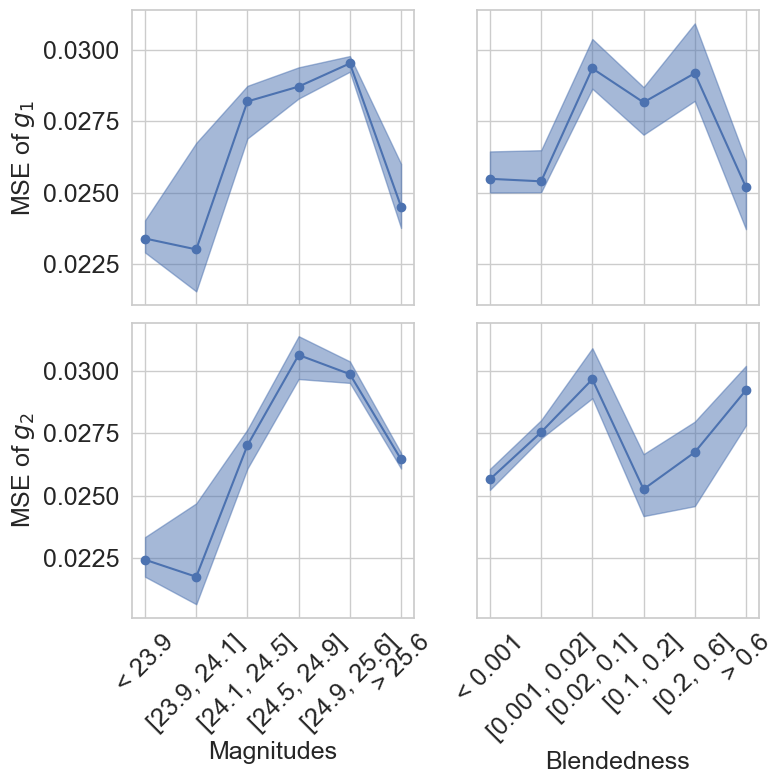

In [23]:
quantile_points = torch.tensor([0.05, 0.5, 0.95])
g1_mse_mag, g2_mse_mag = calculate_mse(bliss_mag_results, quantile_points=quantile_points)
g1_mse_blendedness, g2_mse_blendedness = calculate_mse(bliss_blendedness_results, quantile_points=quantile_points)
g1g2_fig = plot_with_error_bar(g1_mse_mag, g1_mse_blendedness, g2_mse_mag, g2_mse_blendedness, 
                               mag_bin_cutoffs=mag_bin_cutoffs, blendedness_bin_cutoffs=blendedness_cutoffs)
g1g2_fig.savefig(output_dir / "g1g2.pdf", bbox_inches="tight", dpi=NoteBookVariables.dpi)
g1g2_fig.show()